In [7]:
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
import mplfinance as mpf
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
from tqdm import tqdm, trange

In [8]:
client = CryptoHistoricalDataClient()

In [3]:
def get_data(start, end = None, ticker = "BTC", plot = True, timeframe = "Day"):
    global client
    def preprocess(data):
        data = data.reset_index(level = "timestamp").reset_index(level= "symbol")

        data = data[["open", "high", "low", "close", "volume", "timestamp"]]

        data.index = data["timestamp"]
        data.index = pd.to_datetime(data.index)
        data.drop(columns = ["timestamp"], axis = 1, inplace = True)

        return data

    if end is None:
        end = datetime.now()

    # Make sure the type is correct
    if timeframe == "Week":
        timeframe = TimeFrame.Week
    elif timeframe == "Month":
        timeframe = TimeFrame.Month
    elif timeframe == "Minute":
        timeframe = TimeFrame.Minute
    elif timeframe == "Hour":
        timeframe = TimeFrame.Hour
    else:
        timeframe = TimeFrame.Day

    request_params = CryptoBarsRequest(
        symbol_or_symbols=[f"{ticker}/USD"],
        timeframe=timeframe,
        start=start,
        end=end
    )

    btc_bars = client.get_crypto_bars(request_params)
    data = btc_bars.df

    data = preprocess(data)

    if plot:
        mpf.plot(data, type='candle', mav=(10, 20), volume=True, title=f"{ticker} Candlestick Chart", style='charles')
    return data

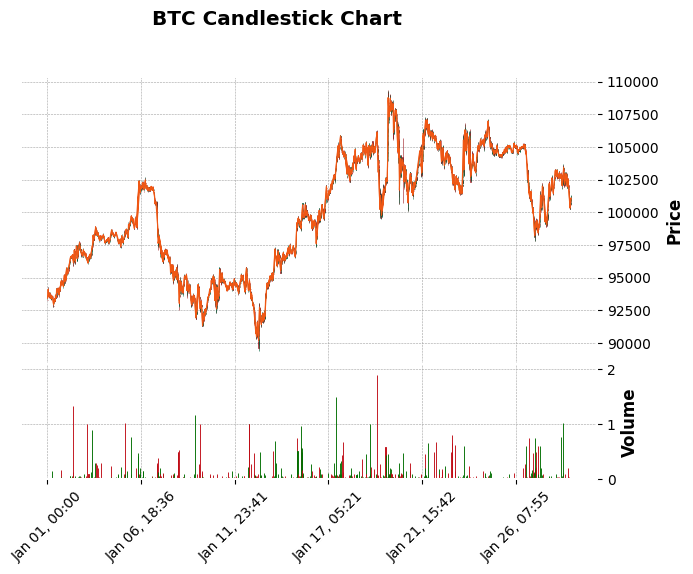

In [4]:
data_minute = get_data(datetime(2025, 1, 1), timeframe = "Minute")

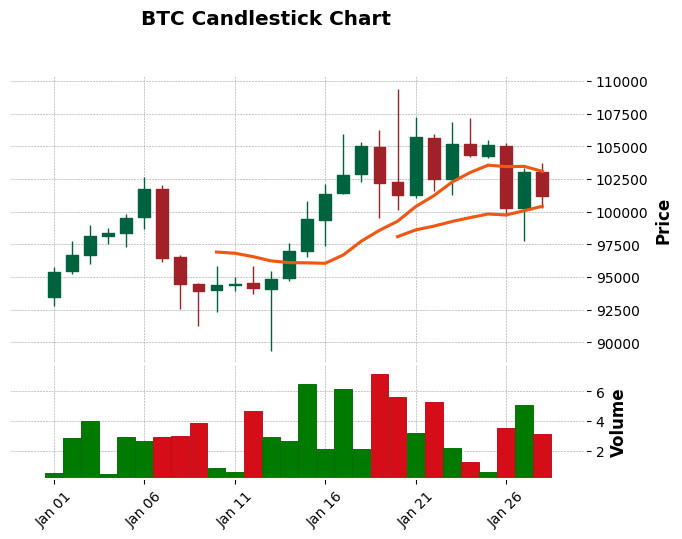

In [5]:
data_day = get_data(datetime(2025, 1, 1), timeframe = "Day")

In [6]:
data_minute

,open,high,low,close,volume
timestamp,,,,,
2025-01-01 00:00:00+00:00,93381.5825,93451.9400,93381.5825,93399.3030,0.000062
2025-01-01 00:01:00+00:00,93469.6285,93469.6285,93469.6285,93469.6285,0.000000
2025-01-01 00:02:00+00:00,93501.8005,93501.8005,93501.8005,93501.8005,0.000000
2025-01-01 00:03:00+00:00,93461.5430,93461.5430,93461.5430,93461.5430,0.000000
2025-01-01 00:06:00+00:00,93405.7060,93405.7060,93405.7060,93405.7060,0.000000
...,...,...,...,...,...
2025-01-28 22:54:00+00:00,100882.9850,100973.2100,100882.9850,100973.2100,0.000000
2025-01-28 22:55:00+00:00,100892.2700,101026.7635,100892.2700,101026.7635,0.000111
2025-01-28 22:56:00+00:00,100977.2215,101098.5340,100977.2215,101098.5340,0.000000


In [39]:
def fractal_fill(df, window_length = 5):
    def bearish_fractal(df, i, window_length):
        flag = 1
        left = i - int(window_length / 2)
        right = i + int(window_length / 2)

        for j in range(left, i):
            flag *= int(df.iloc[j]["high"] < df.iloc[j + 1]["high"])
            
        for j in  range(i, right):
            flag *= int(df.iloc[j]["high"] > df.iloc[j + 1]["high"])
        return bool(flag)

    def bullish_fractal(df, i, window_length):
        flag = 1
        left = i - int(window_length / 2)
        right = i + int(window_length / 2)

        for j in range(left, i):
            flag *= int(df.iloc[j]["low"] > df.iloc[j + 1]["low"])

        for j in range(i, right):
            flag *= int(df.iloc[j]["low"] < df.iloc[j + 1]["low"])
        return bool(flag)
    
    N = len(df)
    df["fractal_type"] = None
    i = 0
    for _, row in tqdm(df.iterrows(), total = N):
        if (i - window_length / 2) < 0 or (i +  window_length) >= N:
            i += 1
            continue
        
        if bearish_fractal(df, i, window_length):
            df.loc[df.index[i], "fractal_type"] = "bearish"
        if bullish_fractal(df, i, window_length):
            df.loc[df.index[i], "fractal_type"] = "bullish"
        i += 1

    return df

In [41]:
data_minute_filled = fractal_fill(data_minute)

100%|██████████| 27945/27945 [00:54<00:00, 511.83it/s]


In [40]:
data_day_filled = fractal_fill(data_day)
data_day_filled

100%|██████████| 28/28 [00:00<00:00, 493.99it/s]


,open,high,low,close,volume,fractal_type
timestamp,,,,,,
2025-01-01 06:00:00+00:00,93486.630000,95791.832000,92772.200000,95408.097000,0.489131,None
2025-01-02 06:00:00+00:00,95469.822500,97784.170750,95208.500000,96693.125000,2.835025,None
2025-01-03 06:00:00+00:00,96677.915000,98946.186500,96028.515000,98130.977500,4.020980,None
2025-01-04 06:00:00+00:00,98129.682500,98744.462000,97551.235000,98369.453500,0.478900,None
2025-01-05 06:00:00+00:00,98346.600000,99832.671000,97296.485732,99544.750000,2.957552,None
2025-01-06 06:00:00+00:00,99597.010500,102692.500000,98690.058500,101754.340500,2.679848,bearish
2025-01-07 06:00:00+00:00,101727.419000,102040.457000,96113.238000,96480.020000,2.938081,None
2025-01-08 06:00:00+00:00,96547.409000,96669.500000,92551.150000,94440.400000,2.978686,None
2025-01-09 06:00:00+00:00,94492.155500,94571.250000,91260.400000,93933.150000,3.862679,bullish
